In [1]:
import sys
sys.path.insert(0,'C:\\Users\\Jacob\\Documents\\GitHub\\lenskit_confidence')

In [2]:
from lenskit.metrics import predict
import pandas as pd
import matplotlib.pyplot as plt

from lenskit.batch_ca import MultiEval
from lenskit.algorithms_ca import user_knn_ca, Recommender
from lenskit.metrics.predict import rmse
from lenskit import datasets
from lenskit.datasets import MovieLens
from lenskit import crossfold as xf
from lenskit import topn, datasets, batch_ca # *not* batch 
from lenskit import topn, util #, metrics
from lenskit.crossfold import partition_users, SampleN, partition_rows

In [3]:
util.log_to_notebook()

[   INFO] lenskit.util.log notebook logging configured


In [586]:
data = 'ml1m'

In [587]:
#model = 'CIBCF'  ##### DO AGAIN WITH r0 = 5
model = 'CUBCF'

In [588]:
path = 'D:\\results_conf_aware_nbhd_KDD2021\\' + data + '\\confidence_aware\\' + model + '\\'

In [742]:
list_length = 100

In [743]:
runs = pd.read_csv(path + 'runs.csv')
runs.set_index('RunId', inplace = True)
runs.head()

,DataSet,Partition,AlgoClass,AlgoStr,name,nnbrs,TrainTime,PredTime,RecTime
RunId,,,,,,,,,
1,ML-Small,1,UserUserCA,"UserUserCA(nnbrs=10, min_sim=0)",UserKNN-CA-Average,10,6.290114,NaN,45.660117
2,ML-Small,1,UserUserCA,"UserUserCA(nnbrs=25, min_sim=0)",UserKNN-CA-Average,25,0.435620,NaN,48.289253
3,ML-Small,1,UserUserCA,"UserUserCA(nnbrs=50, min_sim=0)",UserKNN-CA-Average,50,0.442322,NaN,52.940986
4,ML-Small,1,UserUserCA,"UserUserCA(nnbrs=75, min_sim=0)",UserKNN-CA-Average,75,0.423000,NaN,53.565444
5,ML-Small,1,UserUserCA,"UserUserCA(nnbrs=10, min_sim=0)",UserKNN-CA-JK-Average,10,0.413594,NaN,59.119947


In [744]:
recs = pd.read_parquet(path + 'recommendations.parquet')
recs.head()

,item,prediction,user,var,num_nbhr,rank,RunId
0,1420,4.256927,1,0.245267,3.0,1,1
1,1002,4.012095,1,0.198350,3.0,2,1
2,2197,3.338030,1,0.256608,5.0,3,1
3,2503,2.510929,1,0.321729,6.0,4,1
4,53,1.984779,1,0.098031,2.0,5,1


In [745]:
recs['prediction'] = (recs['prediction']*recs['var']) + 4.5
recs.head()

,item,prediction,user,var,num_nbhr,rank,RunId
0,1420,5.544083,1,0.245267,3.0,1,1
1,1002,5.295800,1,0.198350,3.0,2,1
2,2197,5.356565,1,0.256608,5.0,3,1
3,2503,5.307838,1,0.321729,6.0,4,1
4,53,4.694570,1,0.098031,2.0,5,1


In [746]:
new_r0 = 3.5

In [747]:
recs['score'] = (recs['prediction'] - new_r0)/recs['var']
recs.head()

,item,prediction,user,var,num_nbhr,rank,RunId,score
0,1420,5.544083,1,0.245267,3.0,1,1,8.334120
1,1002,5.295800,1,0.198350,3.0,2,1,9.053685
2,2197,5.356565,1,0.256608,5.0,3,1,7.235024
3,2503,5.307838,1,0.321729,6.0,4,1,5.619138
4,53,4.694570,1,0.098031,2.0,5,1,12.185607


In [748]:
recs['rank'] = recs.groupby(['user', 'num_nbhr'])['score'].rank("dense", ascending = False)

In [749]:
recs.head()

,item,prediction,user,var,num_nbhr,rank,RunId,score
0,1420,5.544083,1,0.245267,3.0,10.0,1,8.334120
1,1002,5.295800,1,0.198350,3.0,9.0,1,9.053685
2,2197,5.356565,1,0.256608,5.0,5.0,1,7.235024
3,2503,5.307838,1,0.321729,6.0,5.0,1,5.619138
4,53,4.694570,1,0.098031,2.0,28.0,1,12.185607


In [750]:
recs[recs['user'] == 3].sort_values(by = ['user', 'num_nbhr', 'rank'])

,item,prediction,user,var,num_nbhr,rank,RunId,score
3624008,3382,7.031304,3,3.000000,1.0,1.0,37,1.177101
3744806,3382,7.031304,3,3.000000,1.0,1.0,38,1.177101
3865606,3382,7.031304,3,3.000000,1.0,1.0,39,1.177101
4107206,3382,7.031304,3,3.000000,1.0,1.0,40,1.177101
4228006,3382,7.031304,3,3.000000,1.0,1.0,41,1.177101
...,...,...,...,...,...,...,...,...
4107297,3000,4.465591,3,0.891157,75.0,163.0,40,1.083525
4590488,2571,4.487026,3,0.914126,75.0,164.0,44,1.079749
4107285,3307,4.489897,3,0.917300,75.0,165.0,40,1.079142
4590498,3000,4.465591,3,0.895409,75.0,166.0,44,1.078379


In [751]:
recs['score'] = recs['prediction']

In [752]:
recs = recs[['item', 'score', 'user','rank','RunId']]
recs.head()

,item,score,user,rank,RunId
0,1420,5.544083,1,10.0,1
1,1002,5.295800,1,9.0,1
2,2197,5.356565,1,5.0,1
3,2503,5.307838,1,5.0,1
4,53,4.694570,1,28.0,1


In [753]:
recs = recs[recs['rank'] <= list_length]

In [754]:
truth = pd.read_csv(path + 'truth.csv')
truth = truth[['user', 'item', 'rating']]
truth.head()

,user,item,rating
0,1,1097,4.0
1,1,3408,4.0
2,1,150,5.0
3,1,2340,3.0
4,1,260,4.0


In [755]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg) # precision, recall, recip_rank, dcg, ndcg
rla.add_metric(topn.precision)
raw_ndcg = rla.compute(recs, truth)
raw_ndcg.head()

[   INFO] lenskit.topn analyzing 5471583 recommendations (30200 truth rows)
[   INFO] lenskit.topn using rec key columns ['RunId', 'user']
[   INFO] lenskit.topn using truth key columns ['user']
[   INFO] lenskit.topn collecting truth data
[   INFO] lenskit.topn collecting metric results
[   INFO] lenskit.sharing.shm serialized <lenskit.topn._RLAJob object at 0x000001F9823642B0> to 1474914 pickle bytes with 12084 buffers of 241232852 bytes
[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 2 workers
[   INFO] lenskit.topn measured 72480 lists in 2m34.42s


nrecs      ndcg  precision
RunId user                            
1     1      42.0  0.000000   0.000000
      14    100.0  0.039505   0.010000
      19     50.0  0.000000   0.000000
      23     84.0  0.063669   0.011905
      24     42.0  0.000000   0.000000

In [756]:
### FOR NEIGHBORHOOD-BASED METHODS ONLY ###
ndcg = raw_ndcg.join(runs[['name', 'nnbrs']], on = 'RunId')
ndcg.head()

nrecs      ndcg  precision                name  nnbrs
RunId user                                                       
1     1      42.0  0.000000   0.000000  UserKNN-CA-Average     10
      14    100.0  0.039505   0.010000  UserKNN-CA-Average     10
      19     50.0  0.000000   0.000000  UserKNN-CA-Average     10
      23     84.0  0.063669   0.011905  UserKNN-CA-Average     10
      24     42.0  0.000000   0.000000  UserKNN-CA-Average     10

In [757]:
### FOR NEIGHBORHOOD-BASED METHODS ONLY ###
ndcg.fillna(0).groupby(['name', 'nnbrs'])['ndcg','precision'].mean()

<ipython-input-757-9f49e897c919>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ndcg.fillna(0).groupby(['name', 'nnbrs'])['ndcg','precision'].mean()


ndcg  precision
name                  nnbrs                     
UserKNN-CA-Average    10     0.021518   0.004501
                      25     0.023822   0.004800
                      50     0.025289   0.005045
                      75     0.026673   0.005306
UserKNN-CA-BS-Average 10     0.023662   0.004651
                      25     0.024360   0.004899
                      50     0.025528   0.005130
                      75     0.026754   0.005340
UserKNN-CA-JK-Average 10     0.020930   0.004416
                      25     0.023495   0.004692
                      50     0.025311   0.004987
                      75     0.026684   0.005249

In [758]:
ndcg.fillna(0).groupby(['name', 'nnbrs'])['ndcg','precision'].mean().to_csv(path + 'results' + str(eval('list_length')) + '.csv')

<ipython-input-758-421ddbff440e>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ndcg.fillna(0).groupby(['name', 'nnbrs'])['ndcg','precision'].mean().to_csv(path + 'results' + str(eval('list_length')) + '.csv')


Text(0, 0.5, 'nDCG')

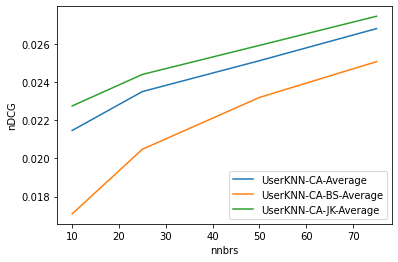

In [565]:
### FOR NEIGHBORHOOD-BASED METHODS ONLY ###
mf_scores = ndcg.groupby(['name', 'nnbrs'])['ndcg'].mean().reset_index()
#pop_score = ndcg[ndcg['AlgoClass'] == 'Popular']['ndcg'].mean()
#plt.axhline(pop_score, color='grey', linestyle='--', label='Popular')
for algo, data in mf_scores.groupby('name'):
    plt.plot(data['nnbrs'], data['ndcg'], label=algo)
plt.legend()
plt.xlabel('nnbrs')
plt.ylabel('nDCG')

In [ ]:
### FOR NEIGHBORHOOD-BASED METHODS ONLY ###
mf_scores = ndcg.groupby(['name', 'nnbrs'])['precision'].mean().reset_index()
#pop_score = ndcg[ndcg['AlgoClass'] == 'Popular']['ndcg'].mean()
#plt.axhline(pop_score, color='grey', linestyle='--', label='Popular')
for algo, data in mf_scores.groupby('name'):
    plt.plot(data['nnbrs'], data['precision'], label=algo)
plt.legend()
plt.xlabel('nnbrs')
plt.ylabel('Precision')